The second parameter of the dist.Beta(1, alpha) distribution is the concentration parameter of the Dirichlet Process. This parameter has a significant impact on the number of clusters the model will favor:
A small alpha (like your current value of 0.1) tells the model that the data was likely generated by a small number of large clusters. This prior is so strong that the model is failing to identify the four distinct groups in your data, and is instead trying to force the data into fewer clusters, leading to the incorrect assignments you see in the plot.
A large alpha encourages the model to create more clusters, with the mass of the Dirichlet Process being distributed more evenly among them.

### High-Level Goal: Probabilistic Clustering

The ultimate goal of this model is to perform clustering. Unlike algorithms like K-Means where you must specify the number of clusters (`K`) beforehand, this model attempts to *infer* the number of clusters from the data itself.

It does this by framing the problem probabilistically:
1.  Assume there is a potentially infinite number of clusters (or "components").
2.  Each cluster is a Gaussian distribution with its own mean and covariance matrix.
3.  Each data point is generated by first picking a cluster and then drawing the point from that cluster's Gaussian distribution.
4.  The "popularity" or weight of each cluster is also a random variable.

The model uses Bayesian inference (specifically, MCMC) to find the posterior distribution of all these unknown quantities: the cluster weights, the cluster means/covariances, and by extension, the cluster assignments for each data point.

---

### Deep Dive into the `dpmm_marginal` Model

The function `dpmm_marginal` defines the **generative process** for the data. In probabilistic programming, you describe how you believe the data came into being, and the inference engine (NUTS/MCMC) works backward from the observed data to figure out the parameters of that process.

#### **Step 1: Stick-Breaking Weights**

A  Dirichlet Process allows for an infinite number of clusters. Since we can't compute with infinities, we use a finite approximation. The **stick-breaking process** is a constructive way to generate weights that sum to 1, which can be used as probabilities for a categorical distribution.

*   **`T=10`**: This is the **truncation level**. We are pre-allocating a maximum of `T` possible clusters. This `T` should be chosen to be larger than the number of clusters you realistically expect to find. If the data only supports 4 clusters, the model will learn to assign near-zero weight to the other 6 components.

*   **`alpha = numpyro.sample("alpha", dist.Gamma(1.0, 1.0))`**
    *   **What it is:** `alpha` is the **concentration parameter** of the Dirichlet Process. It's a hyperparameter that controls the cluster distribution.
    *   **Why it's made:** `alpha` governs how the weights are distributed.
        *   A **low `alpha`** encourages the model to put most of the weight on a few "sticks," leading to a smaller number of active clusters. 
        *   A **high `alpha`** encourages the weights to be more evenly distributed, making it easier for new clusters to be utilized.
    *   **Mathematical Operation:** We are not fixing `alpha` but learning it from the data. We place a `Gamma(1,1)` prior on it, which is a common, weakly informative prior for a positive real number. 

*   **`beta = numpyro.sample("beta", dist.Beta(1, alpha).expand([T-1]).to_event(1))`**
    *   **What it is:** `beta` represents the proportions of the "stick" that are broken off at each step. We need `T-1` breaks to create `T` stick pieces.
    *   **Why it's made:** This is the core mechanic of the stick-breaking construction. Imagine a stick of length 1.
        1.  `beta[0]` is drawn from `Beta(1, alpha)`. This determines the length of the first piece of the stick.
        2.  `beta[1]` is drawn from `Beta(1, alpha)`. This determines the proportion of the *remaining* stick to break off for the second piece.
        3.  And so on.
    *   **Mathematical Operation:** We sample `T-1` independent values from a `Beta(1, alpha)` distribution. The `.expand([T-1])` creates the `T-1` samples, and `.to_event(1)` tells NumPyro to treat this as a single `(T-1)`-dimensional random variable.

*   **`w = numpyro.deterministic("w", dist.transforms.StickBreakingTransform()(beta))`**
    *   **What it is:** `w` is the vector of `T` final cluster weights.
    *   **Why it's made:** This transforms the `beta` proportions into the final weights `w` that sum to 1.
    *   **Mathematical Operation:** The `StickBreakingTransform` performs the following calculation:
        *   `w[0] = beta[0]`
        *   `w[1] = (1 - beta[0]) * beta[1]`
        *   `w[2] = (1 - beta[0]) * (1 - beta[1]) * beta[2]`
        *   ...
        *   `w[k] = beta[k] * product_{j=0}^{k-1} (1 - beta[j])`
        The last weight, `w[T-1]`, takes up all the remaining length of the stick to ensure `sum(w) = 1`. `numpyro.deterministic` registers this transformed variable so we can inspect its posterior distribution later.

---

#### **Step 2: Component Parameters**

Now that we have weights for our `T` potential clusters, we need to define the parameters for each cluster's distribution. Here, we assume each cluster is a Multivariate Gaussian.

*   **`with numpyro.plate("components", T):`**
    *   **What it is:** A `plate` is NumPyro's syntax for declaring conditional independence. It's like a `for` loop in probabilistic modeling.
    *   **Why it's made:** It tells the model: "The code inside this block should be executed `T` times. Each execution creates a new, independent set of parameters for one of the `T` components." This is how we get `T` different means (`mu`) and `T` different covariance matrices.

*   **`mu = numpyro.sample("mu", dist.MultivariateNormal(loc=data_mean, ...))`**
    *   **What it is:** The means of the `T` Gaussian components. The final shape will be `(T, D)`.
    *   **Why it's made:** Each cluster needs a center. We place a weakly informative prior on these means. The prior is centered on the overall mean of the data (`data_mean`) with a large covariance (`10.0 * jnp.eye(D)`), suggesting that the cluster centers are probably somewhere "around" the data, but we're not too certain. This is a much better starting point than, say, a `Normal(0, 1)` prior if the data is centered at `(50, 50)`.
    *   **Mathematical Operation:** Sample `T` vectors, each of dimension `D`, from a `MultivariateNormal` distribution.

*   **Decomposing the Covariance Matrix: `sigma` and `Lcorr`**
    Modeling covariance matrices directly is difficult because they must be symmetric and positive semi-definite. A modern, numerically stable approach is to decompose the covariance matrix `S` into standard deviations `sigma` and a correlation matrix `R`: `S = diag(sigma) @ R @ diag(sigma)`. The correlation matrix `R` is then further decomposed via Cholesky decomposition: `R = L_corr @ L_corr.T`. We put priors on `sigma` and `L_corr`.

*   **`sigma = numpyro.sample("sigma", dist.HalfCauchy(1.0).expand([D]).to_event(1))`**
    *   **What it is:** The standard deviations along each of the `D` dimensions for each of the `T` components. The shape will be `(T, D)`.
    *   **Why it's made:** This defines the scale or spread of each cluster in each dimension. A `HalfCauchy` is a good, weakly informative prior for scale parameters (standard deviations), as it has a heavy tail, allowing for very large values if the data supports them.
    *   **Mathematical Operation:** For each of the `T` components, sample `D` independent values from a `HalfCauchy(1.0)` distribution.

*   **`Lcorr = numpyro.sample("Lcorr", dist.LKJCholesky(dimension=D, concentration=1.0))`**
    *   **What it is:** The Cholesky factor of the correlation matrix for each of the `T` components. `Lcorr` is a lower-triangular matrix. The shape will be `(T, D, D)`.
    *   **Why it's made:** The `LKJCholesky` distribution is a prior specifically for Cholesky factors of correlation matrices. It elegantly handles the constraint that the resulting matrix must be a valid correlation matrix. The `concentration` parameter works similarly to `alpha` in the DP: a value of `1.0` is a uniform prior over all correlation matrices; values `> 1` push it towards the identity matrix (no correlation); values `< 1` push it towards stronger correlations.
    *   **Mathematical Operation:** For each of the `T` components, sample one `(D, D)` lower-triangular matrix from the `LKJCholesky` distribution.

*   **`scale_tril = sigma[..., None] * Lcorr`**
    *   **What it is:** The Cholesky factor of the final covariance matrix for each of the `T` components. Shape is `(T, D, D)`.
    *   **Why it's made:** This reassembles the standard deviations and correlations into the final parameter needed for `MultivariateNormal`. Using the Cholesky factor (`scale_tril`) is more numerically stable and efficient than forming the full covariance matrix.
    *   **Mathematical Operation:** This is a broadcasted matrix multiplication.
        *   `sigma` has shape `(T, D)`. `sigma[..., None]` adds a new dimension at the end, making its shape `(T, D, 1)`.
        *   `Lcorr` has shape `(T, D, D)`.
        *   JAX broadcasts the `(T, D, 1)` array across the columns of the `(T, D, D)` array. Effectively, for each of the `T` components, it scales the rows of `Lcorr` by the corresponding standard deviations in `sigma`. This correctly computes `diag(sigma) @ L_corr`.

---

#### **Step 3: Marginal Mixture over Observations**

This is the final step where we connect the model parameters to the observed data.

*   **`mix = MixtureSameFamily(...)`**
    *   **What it is:** This creates a single, unified distribution object representing the entire mixture model.
    *   **Why it's made:** This is a crucial step for efficiency. Instead of explicitly sampling a cluster assignment `z_i` for each data point `x_i`, `MixtureSameFamily` *marginalizes out* (or integrates out) this discrete choice. The probability of observing a data point `x` is calculated as the weighted sum over all components:
        `p(x | w, mu, scale_tril) = sum_{k=1}^{T} w[k] * Normal(x | mu[k], S[k])`
        This makes the posterior landscape smoother and easier for gradient-based samplers like NUTS to explore.
    *   **Mathematical Operation:** It takes two key arguments:
        1.  **`Categorical(probs=w)`**: The mixing distribution. This says "a component will be chosen according to the probabilities in `w`."
        2.  **`MultivariateNormal(loc=mu, scale_tril=scale_tril)`**: The component distribution. This is a batch of `T` different Multivariate Normal distributions, one for each component.

*   **`numpyro.sample("obs", mix, obs=data)`**
    *   **What it is:** The likelihood statement. This is the most important line in the model.
    *   **Why it's made:** It asserts that our observed `data` (all `N` points) are drawn from the `mix` distribution we just defined. This grounds the abstract model in reality. The MCMC algorithm will now try to find parameter values (`alpha`, `beta`, `mu`, etc.) that make this statement as probable as possible, while also respecting the priors we set.
    *   **Mathematical Operation:** This calculates the log-likelihood of the data given the current values of all the upstream parameters. This log-likelihood is the `P(data | params)` term in Bayes' Theorem, and its gradient is what powers the NUTS sampler.

---




### The Two Ways to Formulate a Mixture Model

Imagine you have a mixture model. To generate a single data point `xᵢ`, the complete process involves two steps:

1.  **Choose a cluster:** A latent (unobserved) variable, let's call it `zᵢ`, is drawn from a Categorical distribution defined by the cluster weights `w`. So, `zᵢ` could be 0, 1, 2, ..., T-1.
2.  **Generate data from that cluster:** The data point `xᵢ` is then drawn from the distribution of the chosen cluster. For example, if `zᵢ = k`, then `xᵢ` is drawn from `MultivariateNormal(μ[k], Σ[k])`.

This describes the **full generative process**. When we write a model that includes this explicit `zᵢ` variable for each data point, we call it the **"complete"** or **"explicit" model**.

However, there is another way.

### The "Marginal" Approach

In probability, to "marginalize out" a variable means to sum or integrate over all its possible values to get the probability of the other variables.

The probability of observing a single data point `xᵢ` *without knowing which cluster it came from* is the sum of probabilities over all possible cluster choices:

`P(xᵢ | params) = Σ_{k=0}^{T-1} P(xᵢ, zᵢ=k | params)`
`P(xᵢ | params) = Σ_{k=0}^{T-1} P(xᵢ | zᵢ=k, params) * P(zᵢ=k | params)`

Let's substitute the actual distributions:

`P(xᵢ | μ, Σ, w) = Σ_{k=0}^{T-1} [ MultivariateNormal(xᵢ | μ[k], Σ[k]) * w[k] ]`

This final expression is the **marginal likelihood** of the data point `xᵢ`, where the discrete cluster assignment `zᵢ` has been "summed out" or "marginalized out".


*   **Marginal Model (Your Code):** Uses `numpyro.distributions.MixtureSameFamily`. This distribution object does the marginalization for you. Its `log_prob` method directly computes the log of the summation formula shown above.

---

### Why is the Marginal Formulation Used?

So, why go to the trouble of marginalizing? Why not just model the "complete" process with the explicit `z` variables? The answer is purely for **computational efficiency and effectiveness**, especially when using gradient-based samplers like NUTS.

1.  **Dealing with Discrete Latent Variables:**
    *   NUTS (and HMC in general) works by computing the gradient of the log-probability of the model with respect to its parameters. It uses this gradient to guide its exploration of the parameter space.
    *   A discrete latent variable like `zᵢ` introduces a major problem: **you cannot compute a gradient with respect to a discrete parameter.** The probability landscape becomes a series of disconnected points, not a smooth surface that NUTS can navigate.
    *   By marginalizing out `zᵢ`, we remove all the discrete latent variables from the model. The resulting log-probability is now a smooth, differentiable function of all the remaining continuous parameters (`alpha`, `beta`, `mu`, `sigma`, `Lcorr`). This makes it perfectly suited for NUTS.

2.  **Improved Sampler Performance (Better "Mixing"):**
    *   In the explicit model, the sampler can get stuck. The parameters for a cluster `k` (i.e., `μ[k]`, `Σ[k]`) are only updated based on the data points currently assigned to it (`zᵢ = k`). If no points are assigned to a cluster, its parameters don't get updated. This creates a "chicken-and-egg" problem that can cause the sampler to mix very slowly.
    *   In the marginal model, every data point contributes to the update of *every* cluster's parameters at *every* step of the MCMC. The gradient for `μ[k]` receives a contribution from every single data point `xᵢ`, weighted by that point's probability of belonging to cluster `k`. This allows all parameters to be updated simultaneously and smoothly, leading to much faster convergence and more effective exploration of the posterior.

### Summary Table: Explicit vs. Marginal

| Feature                 | Explicit / Complete Model                                   | **Marginal Model (Your Code)**                                  |
| ----------------------- | ----------------------------------------------------------- | --------------------------------------------------------------- |
| **Key Idea**            | Model the full generative process, including `zᵢ`.            | Analytically integrate out `zᵢ` before inference.               |
| **Latent Variables**    | Continuous (`μ`, `Σ`, etc.) AND Discrete (`zᵢ`).             | **Only** continuous (`μ`, `Σ`, etc.).                           |
| **Likelihood (`obs`)**  | `dist.MultivariateNormal(loc=mu[z], ...)`                   | `dist.MixtureSameFamily(Categorical(w), MVN(μ, Σ))`             |
| **Compatibility (NUTS)**| **Poor.** Requires workarounds like Gibbs sampling for `zᵢ`. | **Excellent.** The log-probability is smooth and differentiable. |
| **Performance**         | Slower mixing, higher sample autocorrelation.               | Faster mixing, more efficient exploration of the posterior.     |
| **Primary Use Case**    | When you absolutely need posterior samples of `zᵢ` itself.    | **Standard, preferred approach for gradient-based MCMC.**       |

In conclusion, the name **`dpmm_marginal`** is a very precise descriptor. It signals that this is a Dirichlet Process Mixture Model implemented using the computationally superior strategy of **marginalizing out the discrete cluster assignment variables**.

Imagine you have a big bag of unlabeled photos, and you want to sort them into groups of similar pictures. For instance, you might have photos of cats, dogs, and sunsets. A Dirichlet Process Gaussian Mixture Model (DPGMM) is like a smart sorting machine that can figure out these groups for you, even if you don't know how many groups there are beforehand. 

 ### The Big Idea: Clustering Your Data 

 At its core, DPGMM is used for **clustering**, which is just a fancy word for grouping similar things together. Think of it like this: you look at your photos and decide that some look like they belong to a "cat" pile, others to a "dog" pile, and the rest to a "sunset" pile. 

 ### The "Gaussian Mixture Model" Part: Describing the Groups 

 Now, let's break down the name. A **Gaussian Mixture Model (GMM)** assumes that your data points within each group follow a "bell curve" pattern, also known as a Gaussian distribution. 

 *   **What's a Gaussian distribution?** Imagine you measure the heights of all the students in your school. Most students will have an average height, with fewer students being very short or very tall. If you plot this, you'll get a bell-shaped curve. This is a Gaussian distribution. It's defined by its center (the average) and its spread (how wide the bell is). 

 *   **Mixture of Gaussians:** A GMM says that your entire dataset is a mix of several of these bell curves. Each bell curve represents one of the groups or clusters. So, in our photo example, the "cat" photos would have their own bell curve of features (like pointy ears and whiskers), the "dog" photos another, and the "sunset" photos a third. 

 Here's the catch with a standard GMM: you have to tell it exactly how many groups to look for. If you say "find three groups," it will try to fit everything into three bell curves, even if there are actually four or five distinct types of photos. 

 ### The "Dirichlet Process" Part: The Magic Ingredient 

 This is where the **Dirichlet Process (DP)** comes in. The DP is a clever mathematical tool that lets the model figure out the number of groups on its own. You don't need to specify the number of clusters beforehand. It essentially allows for an infinite number of possible groups, and then it picks the number that best fits your data. 

 Think of it like a restaurant with an infinite number of tables, an idea called the **"Chinese Restaurant Process"**: 

 *   The first person to walk into the restaurant sits at the first table. 
 *   The second person can either sit at the first table with the first person or start a new table. 
 *   Each new person who comes in can either join an existing table (with a probability proportional to how many people are already there) or start a new one. 

 In this analogy, the people are your data points, and the tables are the clusters. The more popular a table (cluster) is, the more likely a new data point is to join it. But there's always a chance of a new data point starting a completely new table (cluster). This allows the number of clusters to grow as needed based on the data. 

 Another way to think about the Dirichlet Process is the **"stick-breaking process"**: 

 *   Imagine you have a stick of a certain length. You break off a piece of it. The length of that piece represents the importance of the first cluster. 
 *   You then take the remaining part of the stick and break off another piece. The length of this second piece represents the importance of the second cluster. 
 *   You continue this process, and each time the piece you break off gets smaller. 

 This process allows you to create a potentially infinite number of clusters, but in practice, the later clusters will have very little importance (tiny pieces of the stick) and can often be ignored. 

 ### The Steps Involved in DPGMM: A Simplified Flow 

 Here's a simplified, step-by-step look at how a DPGMM might work its magic: 

 1.  **Start with your data:** You have a collection of data points (our photos). 
 2.  **Initial guess:** The model starts by making a rough guess. It might initially think there's only one big group. 
 3.  **Look at each data point one by one:** For each photo, the model asks a question: 
     *   "Does this photo fit well into any of the existing groups (bell curves)?" 
     *   "Or is it so different that it needs to start a new group?" 
 4.  **Assign to a group:** Based on the answer, the model will either assign the photo to an existing group or create a new one. 
 5.  **Update the groups:** Whenever a photo is added to a group, the model slightly adjusts the shape and center of that group's bell curve to better represent all the photos within it. 
 6.  **Repeat, repeat, repeat:** The model goes through your data many times, constantly re-evaluating where each photo belongs and adjusting the groups. This iterative process is a bit like trying to find the best seating arrangement in a crowded room by having people move around until everyone is happy with their table. 
 7.  **Find the best fit:** Eventually, the model settles on a stable set of groups that best explains the patterns in your data. It will have automatically determined the most likely number of clusters. 

 In essence, a DPGMM is a flexible and powerful way to find hidden groups in your data without having to tell it how many groups to look for. It's like a smart sorting machine that learns as it goes.

#  Generate data

In [1]:
import matplotlib as plt
import jax, jax.numpy as jnp
import numpy as onp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


/home/sosa/work/BI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

data, true_labels = make_blobs(
    n_samples=500, centers=8, cluster_std=0.8,
    center_box=(-10,10), random_state=101
)
N, D = data.shape


In [1]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
m = bi(platform='cpu')

/home/sosa/work/BI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


jax.local_device_count 16


# DPM

In [91]:
from BI import bi

def dpmm_marginal(data, T=10):
    # 1) stick-breaking weights
    alpha = m.dist.gamma(1.0, 10.0,name='alpha')
    beta = m.dist.beta(1, alpha,name='beta',shape=(T-1,))
    w = numpyro.deterministic("w",dist.transforms.StickBreakingTransform()(beta))


    # 2) component parameters
    data_mean = jnp.mean(data, axis=0)
    with numpyro.plate("components", T):
        mu = m.dist.multivariatenormal(loc=data_mean, covariance_matrix=100.0*jnp.eye(D),name='mu')# shape (T, D)        
        sigma = m.dist.halfcauchy(1,shape=(D,),event=1,name='sigma')# shape (T, D)
        Lcorr = m.dist.lkjcholesky(dimension=D, concentration=1.0,name='Lcorr')# shape (T, D, D)

        scale_tril = sigma[..., None] * Lcorr  # shape (T, D, D)

    # 3) marginal mixture over obs
    m.dist.mixturesamefamily(
        mixing_distribution=m.dist.categoricalprobs(w,name='cat', create_obj=True),
        component_distribution=m.dist.multivariatenormal(loc=mu, scale_tril=scale_tril,name='mvn', create_obj=True),
        name="obs",  
        obs=data   
    )
m.data_on_model = dict(data=data)
m.run(dpmm_marginal)  # Optimize model parameters through MCMC sampling

sample: 100%|██████████| 1000/1000 [00:24<00:00, 40.36it/s, 63 steps of size 1.05e-01. acc. prob=0.85]


In [38]:
def dpmm_explicit(data, T=10):
    # --- FIX 1: Correctly get N and D ---
    N, D = data.shape
    alpha = m.dist.gamma(1, 10, name='alpha')
    
    with numpyro.plate("mixture_weights", T-1):
        beta = m.dist.beta(1, alpha,name='beta')
    w = numpyro.deterministic("w", dist.transforms.StickBreakingTransform()(beta))

    # 2) component parameters
    data_mean = jnp.mean(data, axis=0)
    with numpyro.plate("components_plate", T):
        mu = m.dist.multivariatenormal(loc=data_mean, covariance_matrix=10.0 * jnp.eye(D), name='mu')
        sigma = m.dist.halfcauchy(1,shape=(D,),event=1,name='sigma')# shape (T, D)
        Lcorr = m.dist.lkjcholesky(dimension=D, concentration=1.0,name='Lcorr')# shape (T, D, D)

        scale_tril = sigma[..., None] * Lcorr  # shape (T, D, D)
        
    with numpyro.plate("data_plate", N):
        # For each of the N data points, sample a cluster assignment `z`
        z = m.dist.categorical(probs=w, name='z')
        m.dist.multivariatenormal(
            loc=mu[z], 
            covariance_matrix=jnp.eye(D), # Using a simple covariance for now
            obs=data, 
            name='obs'
        )

# --- Run the model ---
m.data_on_model = {
    "data": data
}
# This will likely be very slow or fail to converge well due to the discrete `z`
m.run(dpmm_explicit)

/home/sosa/work/BI/BI/Main/main.py:132: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)
sample: 100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s, 31 steps of size 1.46e-01. acc. prob=0.83]


This code performs posterior clustering analysis for a Dirichlet Process (DP) mixture model using samples from an MCMC run. In nonparametric Bayesian models like the DP, the number of clusters is not fixed in advance; it's inferred from the data. However, interpreting and visualizing the clustering structure from posterior samples can be tricky. This code addresses that by post-processing the MCMC output to estimate a stable clustering.

In [9]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform

# 1. Get posterior samples from the MCMC run
posterior_samples = m.sampler.get_samples()
w_samps = posterior_samples['w']
mu_samps = posterior_samples['mu']
Lcorr_samps = posterior_samples['Lcorr']
sigma_samps = posterior_samples['sigma']

# 2. For each posterior sample, calculate the probability of each point belonging to each cluster
def get_cluster_probs(data, w, mu, sigma, Lcorr):
    scale_tril = sigma[..., None] * Lcorr
    log_liks = dist.MultivariateNormal(mu, scale_tril=scale_tril).log_prob(data[:, None, :])
    # log(w) + log(lik)
    log_probs = jnp.log(w) + log_liks
    # log-sum-exp trick for normalization
    norm_probs = jnp.exp(log_probs - jax.scipy.special.logsumexp(log_probs, axis=-1, keepdims=True))
    return norm_probs

# Vectorize the function to run over all posterior samples efficiently
cluster_probs = jax.vmap(get_cluster_probs, in_axes=(None, 0, 0, 0, 0))(
    data, w_samps, mu_samps, sigma_samps, Lcorr_samps
) # Shape: (num_samples, N, T)

# 3. Create a pairwise similarity matrix
# The probability that point i and point j are in the same cluster, averaged over all samples.
# (cluster_probs.T @ cluster_probs) computes the dot product for each sample
# A.T @ B = sum_k A_ki * B_kj -> prob(i in k) * prob(j in k) summed over k
similarity_matrix = (cluster_probs @ cluster_probs.transpose(0, 2, 1)).mean(axis=0)
similarity_matrix_np = onp.array(similarity_matrix)

# 4. Use a standard clustering algorithm on the similarity matrix
# We need a distance matrix, so we use 1 - similarity
distance_matrix = 1 - similarity_matrix
distance_matrix = 1 - similarity_matrix_np
distance_matrix = (distance_matrix + distance_matrix.T) / 2
onp.fill_diagonal(distance_matrix, 0)
distance_matrix = onp.clip(distance_matrix, a_min=0.0, a_max=None)
# Use a condensed distance matrix for scipy's linkage function
condensed_dist = squareform(distance_matrix)

# Hierarchical clustering
Z = linkage(condensed_dist, 'average')
# Extract a flat clustering. We expect 4 clusters.
#final_labels = fcluster(Z, 5, criterion='maxclust')
distance_threshold = 0.5 
final_labels = fcluster(Z, t=distance_threshold, criterion='distance')

# 5. Evaluate and plot
num_found_clusters = len(onp.unique(final_labels))
print(f"Model found {num_found_clusters} clusters.")

new_ari = adjusted_rand_score(true_labels, final_labels)
print(f"New ARI after post-processing: {new_ari:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=final_labels, palette='viridis', edgecolor='white', s=70)
plt.title(f"Estimated Clusters ({num_found_clusters} found, ARI: {new_ari:.4f})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

AttributeError: 'bi' object has no attribute 'sampler'

# GMM

In [48]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpyro.distributions as dist
import os
import sys
import numpyro
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp

m = bi(platform='cpu')
data, true_labels = make_blobs(
    n_samples=500, centers=8, cluster_std=0.8,
    center_box=(-10,10), random_state=101
)
N, D = data.shape

jax.local_device_count 16


## Kmean for prior mean clusters

In [49]:
means = KMeans(n_clusters=8, random_state=0, n_init=10).fit(data)
initial_means = jnp.array(means.cluster_centers_) 


## Model fit anf predictions

In [67]:
m= bi(platform='cpu')
def gmm(data, K=4): # Here K is the *exact* number of clusters
    alpha_prior = 0.5 * jnp.ones(K)
    w = m.dist.dirichlet(concentration=0.5*alpha_prior, name='weights') 

    # --- CHANGE 2: Use the fixed K instead of T ---
    # 2) component parameters

    with m.dist.plate("components", K): # Use fixed K
        mu = m.dist.multivariatenormal(loc=initial_means, covariance_matrix=10.0*jnp.eye(D), name='mu')        
        sigma = m.dist.halfcauchy(1, shape=(D,), event=1, name='sigma')
        Lcorr = m.dist.lkjcholesky(dimension=D, concentration=1.0, name='Lcorr')

        scale_tril = sigma[..., None] * Lcorr

    # 3) marginal mixture over obs (this part remains almost identical)
    m.dist.mixturesamefamily(
        mixing_distribution=m.dist.categorical(probs=w, create_obj=True),
        component_distribution=m.dist.multivariatenormal(loc=mu, scale_tril=scale_tril, create_obj=True),
        name="obs",
        obs=data
    )

# --- Running the GMM ---
m.data_on_model = {
    "data": data,
    "K": 8  # You must pass the number of clusters you want to find
}

m.run(gmm)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s, 15 steps of size 3.96e-01. acc. prob=0.88]


In [68]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform
import jax
import numpy as onp
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
# This entire block works without modification because it's agnostic
# to how `w` was generated. It just needs the posterior samples.

# 1. Get posterior samples from the GMM run
posterior_samples = m.sampler.get_samples()
w_samps = posterior_samples['weights']
mu_samps = posterior_samples['mu']
Lcorr_samps = posterior_samples['Lcorr']
sigma_samps = posterior_samples['sigma']

# 2. The `get_cluster_probs` function is still valid.
def get_cluster_probs(data, w, mu, sigma, Lcorr):
    scale_tril = sigma[..., None] * Lcorr
    log_liks = dist.MultivariateNormal(mu, scale_tril=scale_tril).log_prob(data[:, None, :])
    log_probs = jnp.log(w) + log_liks
    norm_probs = jnp.exp(log_probs - jax.scipy.special.logsumexp(log_probs, axis=-1, keepdims=True))
    return norm_probs

# 3. The rest of the logic also remains valid.
cluster_probs = jax.vmap(get_cluster_probs, in_axes=(None, 0, 0, 0, 0))(
    data, w_samps, mu_samps, sigma_samps, Lcorr_samps
) # Shape will now be (num_samples, N, K)

similarity_matrix = (cluster_probs @ cluster_probs.transpose(0, 2, 1)).mean(axis=0)
similarity_matrix_np = onp.array(similarity_matrix)

distance_matrix = 1 - similarity_matrix_np
distance_matrix = (distance_matrix + distance_matrix.T) / 2
onp.fill_diagonal(distance_matrix, 0)
distance_matrix = onp.clip(distance_matrix, a_min=0.0, a_max=None)

condensed_dist = squareform(distance_matrix)
# Hierarchical clustering
Z = linkage(condensed_dist, 'average')
# Extract a flat clustering. We expect 4 clusters.
#final_labels = fcluster(Z, 5, criterion='maxclust')
distance_threshold = 0.5 
final_labels = fcluster(Z, t=distance_threshold, criterion='distance')

# 5. Evaluate and plot
num_found_clusters = len(onp.unique(final_labels))
print(f"Model found {num_found_clusters} clusters.")

# 4. Evaluate and plot
new_ari = adjusted_rand_score(true_labels, final_labels)
print(f"GMM Final ARI (Direct Method): {new_ari:.4f}")

Model found 8 clusters.
GMM Final ARI (Direct Method): 0.9644


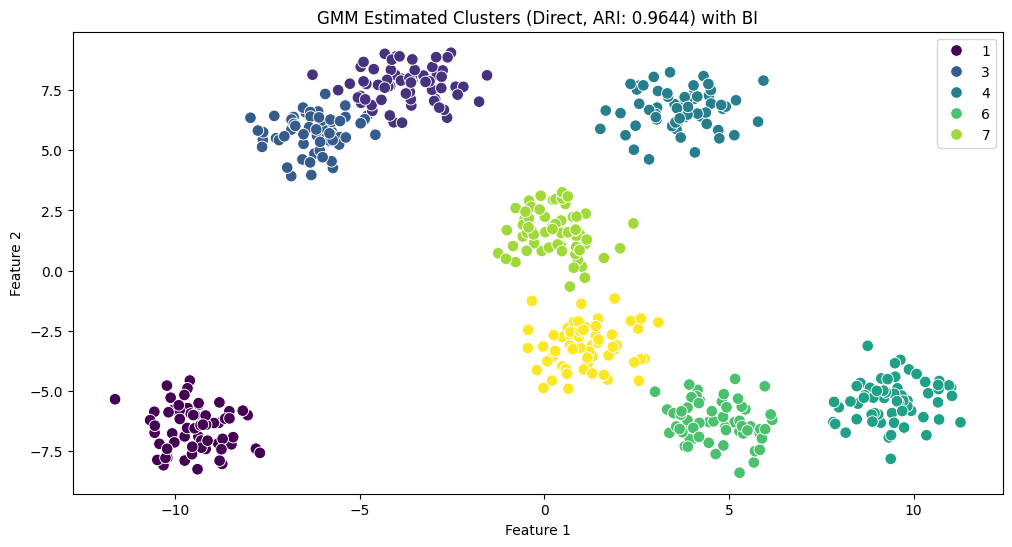

In [69]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=final_labels, palette='viridis', edgecolor='white', s=70)
plt.title(f"GMM Estimated Clusters (Direct, ARI: {new_ari:.4f}) with BI")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [70]:
import numpy as onp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import jax.numpy as jnp

def plot_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Plots an n_std confidence ellipse of a 2D Gaussian distribution.

    Args:
        mean (array-like): The 2D mean of the Gaussian (x, y).
        cov (array-like): The 2x2 covariance matrix.
        ax (matplotlib.axes.Axes): The axes object to plot on.
        n_std (float): The number of standard deviations to visualize.
        facecolor (str): The fill color of the ellipse.
        **kwargs: Additional arguments passed to the Ellipse patch (e.g., edgecolor, lw).
    """
    # Ensure covariance is a 2x2 matrix
    cov = jnp.asarray(cov)
    assert cov.shape == (2, 2), "Covariance matrix must be 2x2."
    
    # Eigen-decomposition of the covariance matrix
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
    
    # The angle of the ellipse is the angle of the first eigenvector
    angle = jnp.degrees(jnp.arctan2(*eigenvectors[:, 0][::-1]))
    
    # The width and height of the ellipse are scaled by the eigenvalues
    width, height = 2 * n_std * jnp.sqrt(eigenvalues)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, **kwargs)
    
    ax.add_patch(ellipse)

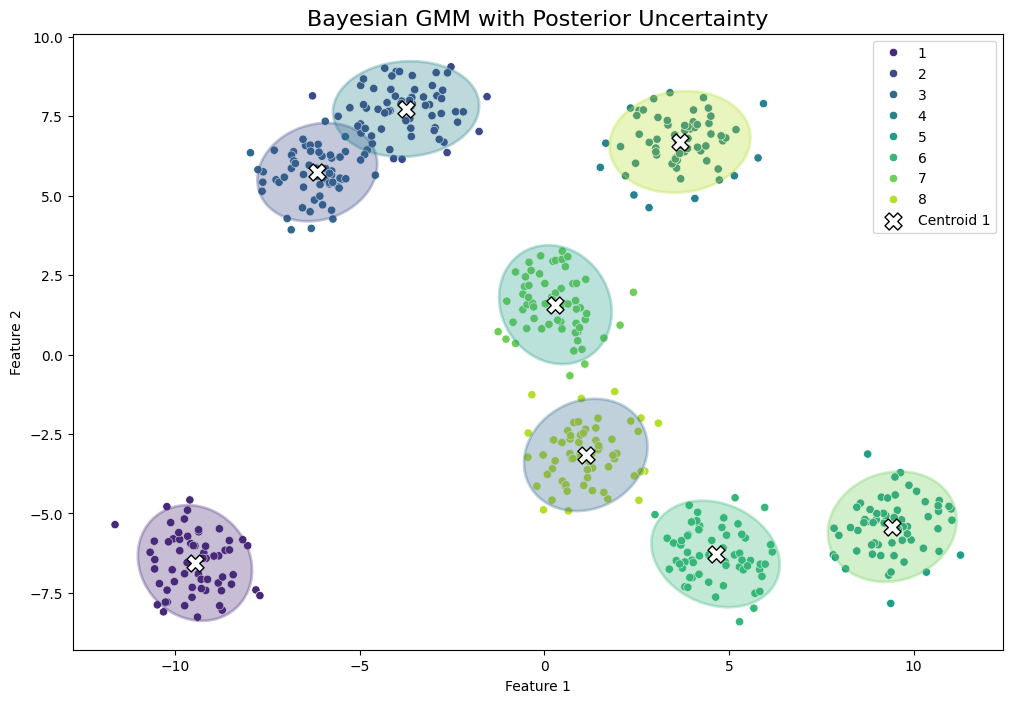

In [71]:
# --- Your existing code to get posterior samples and labels ---
# (I've included it here for completeness)

from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform
import jax
import numpy as onp
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpyro.distributions as dist # Make sure dist is imported

# 1. Get posterior samples from the GMM run
# Assume `m2` is your fitted `bi` model instance
posterior_samples = m2.sampler.get_samples()
w_samps = posterior_samples['weights']
mu_samps = posterior_samples['mu']
Lcorr_samps = posterior_samples['Lcorr']
sigma_samps = posterior_samples['sigma']

# ... (The entire co-clustering block to get final_labels) ...
def get_cluster_probs(data, w, mu, sigma, Lcorr):
    scale_tril = sigma[..., None] * Lcorr
    log_liks = dist.MultivariateNormal(mu, scale_tril=scale_tril).log_prob(data[:, None, :])
    log_probs = jnp.log(w) + log_liks
    norm_probs = jnp.exp(log_probs - jax.scipy.special.logsumexp(log_probs, axis=-1, keepdims=True))
    return norm_probs
cluster_probs = jax.vmap(get_cluster_probs, in_axes=(None, 0, 0, 0, 0))(
    data, w_samps, mu_samps, sigma_samps, Lcorr_samps
)
similarity_matrix = (cluster_probs @ cluster_probs.transpose(0, 2, 1)).mean(axis=0)
similarity_matrix_np = onp.array(similarity_matrix)
distance_matrix = 1 - similarity_matrix_np
distance_matrix = (distance_matrix + distance_matrix.T) / 2
onp.fill_diagonal(distance_matrix, 0)
distance_matrix = onp.clip(distance_matrix, a_min=0.0, a_max=None)
condensed_dist = squareform(distance_matrix)
Z = linkage(condensed_dist, 'average')
distance_threshold = 0.5 
final_labels = fcluster(Z, t=distance_threshold, criterion='distance')
# --- End of your existing code ---


# =======================================================================
# --- NEW CODE FOR PLOTTING WITH UNCERTAINTY ---
# =======================================================================

# 1. Calculate posterior mean of the model parameters
post_mean_mu = jnp.mean(mu_samps, axis=0)
post_mean_sigma = jnp.mean(sigma_samps, axis=0)
post_mean_Lcorr = jnp.mean(Lcorr_samps, axis=0)

# Reconstruct the full covariance matrices from their posterior mean components
post_mean_scale_tril = post_mean_sigma[..., None] * post_mean_Lcorr
post_mean_cov = post_mean_scale_tril @ jnp.transpose(post_mean_scale_tril, (0, 2, 1))

# 2. Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
palette = sns.color_palette("viridis", n_colors=len(onp.unique(final_labels)))

# 3. Plot the data points, colored by their final cluster assignment
sns.scatterplot(
    x=data[:, 0], 
    y=data[:, 1], 
    hue=final_labels, 
    palette=palette, 
    ax=ax,
    legend='full'
)

# 4. Plot the ellipses and centroids for each component
# Note: The component index `k` from the model (0, 1, 2...) may not directly
# map to the hierarchical cluster label (1, 2, 3...). We use a simple color
# mapping here, but the principle holds.
num_components = post_mean_mu.shape[0]
ellipse_palette = sns.color_palette("viridis", n_colors=num_components)

for k in range(num_components):
    # Plot the uncertainty ellipse (e.g., 2 std deviations for ~95% confidence)
    plot_ellipse(
        mean=post_mean_mu[k], 
        cov=post_mean_cov[k], 
        ax=ax, 
        n_std=2.0,
        edgecolor=ellipse_palette[k],
        facecolor=ellipse_palette[k],
        alpha=0.3, # Make it translucent
        lw=2
    )
    
    # Plot the cluster centroid (posterior mean of mu)
    ax.scatter(
        post_mean_mu[k, 0], 
        post_mean_mu[k, 1], 
        marker='X', 
        s=150, 
        color='white', 
        edgecolor='black',
        zorder=10, # Ensure it's on top
        label=f'Centroid {k+1}' if k == 0 else "" # Avoid duplicate labels
    )

ax.set_title("Bayesian GMM with Posterior Uncertainty", fontsize=16)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()

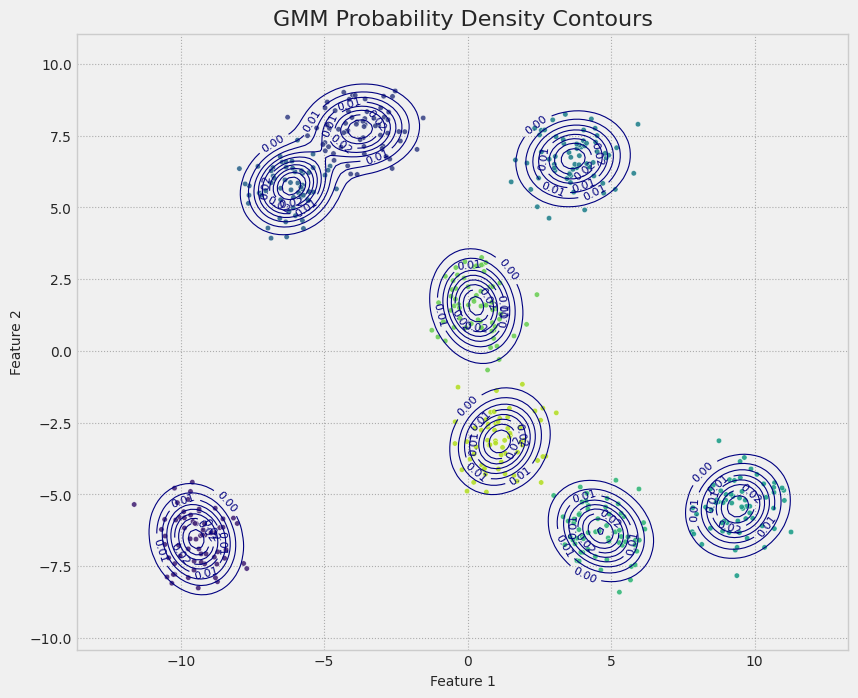

In [84]:
# =======================================================================
# --- CORRECTED CODE FOR DENSITY CONTOUR PLOT ---
# =======================================================================
import numpy as np # Use standard numpy for grid creation and plotting
from scipy.stats import multivariate_normal
import seaborn as sns # Ensure seaborn is imported for palettes
import matplotlib.pyplot as plt

# 1. Calculate posterior mean of all model parameters
post_mean_w = onp.array(jnp.mean(w_samps, axis=0))
post_mean_mu = onp.array(jnp.mean(mu_samps, axis=0))
post_mean_sigma = onp.array(jnp.mean(sigma_samps, axis=0))
post_mean_Lcorr = onp.array(jnp.mean(Lcorr_samps, axis=0))

# Reconstruct the full covariance matrices
post_mean_scale_tril = post_mean_sigma[..., None] * post_mean_Lcorr
post_mean_cov = post_mean_scale_tril @ onp.transpose(post_mean_scale_tril, (0, 2, 1))

# --- The core logic for the new plot starts here ---

# 2. Set up a grid of points to evaluate the GMM density
x_min, x_max = data[:, 0].min() - 2, data[:, 0].max() + 2
y_min, y_max = data[:, 1].min() - 2, data[:, 1].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150),
                     np.linspace(y_min, y_max, 150))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 3. Calculate the PDF of the GMM on the grid
num_components = post_mean_mu.shape[0]
gmm_pdf = np.zeros(grid_points.shape[0])

for k in range(num_components):
    # Get parameters for the k-th component
    weight = post_mean_w[k]
    mean = post_mean_mu[k]
    cov = post_mean_cov[k]

    # Calculate the PDF of this component and add its weighted value to the total
    component_pdf = multivariate_normal(mean=mean, cov=cov).pdf(grid_points)
    gmm_pdf += weight * component_pdf

# Reshape the PDF values to match the grid shape
Z = gmm_pdf.reshape(xx.shape)

# 4. Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('#f0f0f0') 
ax.set_facecolor('#f0f0f0')

# === FIX IS HERE ===
# Dynamically create a color palette based on the number of clusters found
unique_labels = onp.unique(final_labels)
n_clusters = len(unique_labels)
# Using 'viridis' to match your first plot, but 'tab10' or 'Set2' are also good
palette = sns.color_palette("viridis", n_colors=n_clusters) 

# Create a mapping from each cluster label to its assigned color
color_map = {label: palette[i] for i, label in enumerate(unique_labels)}
# Create a list of colors for each data point corresponding to its cluster
point_colors = [color_map[l] for l in final_labels]
# === END OF FIX ===

# Plot the data points using the dynamically generated colors
ax.scatter(data[:, 0], data[:, 1], c=point_colors, s=15, alpha=0.9, edgecolor='white', linewidth=0.3)

# Plot the density contours
# Using a different colormap for the contours (e.g., 'Blues' or 'Reds') can look nice
# to distinguish them from the points. Here we'll use a single color for simplicity.
contour_color = 'navy'
contour = ax.contour(xx, yy, Z, levels=10, colors=contour_color, linewidths=0.8)
ax.clabel(contour, inline=True, fontsize=8, fmt='%.2f')

# Final styling touches
ax.set_title("GMM Probability Density Contours", fontsize=16)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.grid(True, linestyle=':', color='gray', alpha=0.6)
ax.set_aspect('equal', adjustable='box') 

plt.show()

## Comparing with sklearn

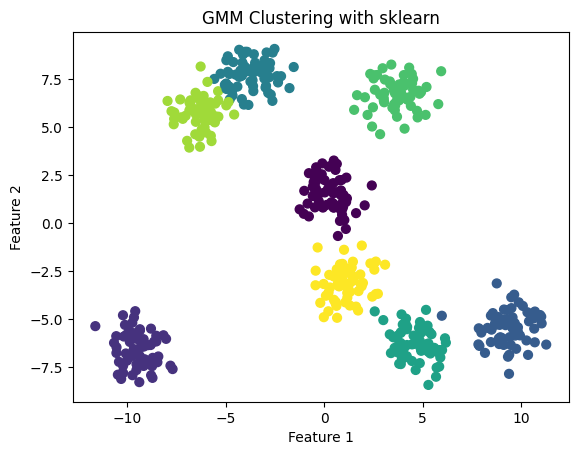

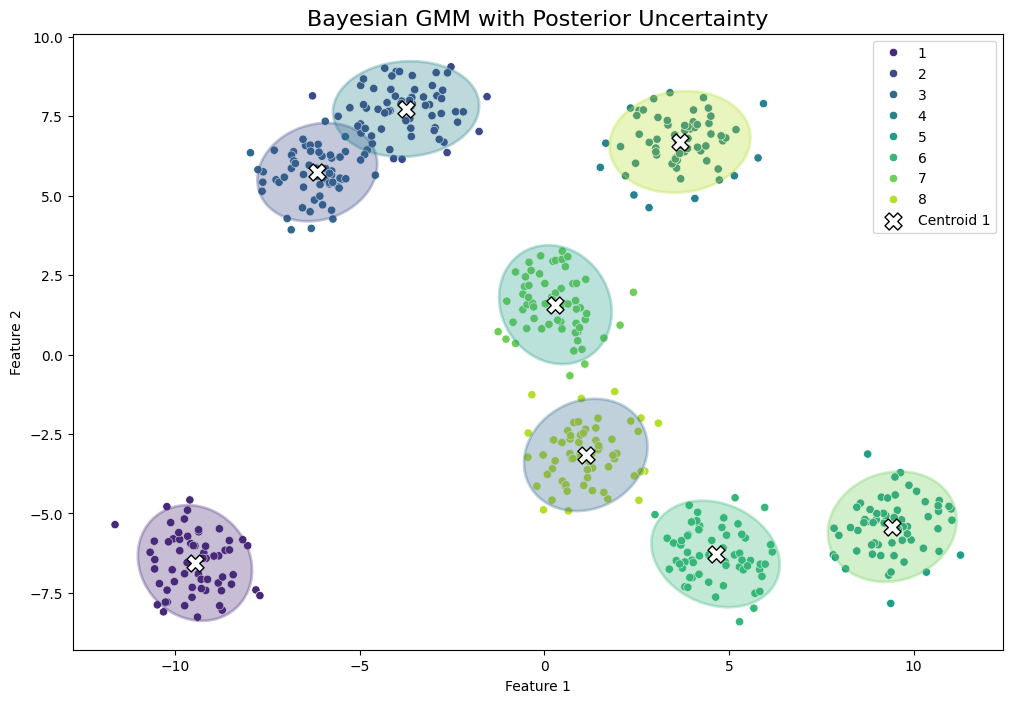

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


# Step 2: Fit a Gaussian Mixture Model
gmm = BayesianGaussianMixture(n_components=8, covariance_type='full', random_state=42)
gmm.fit(data)

# Step 3: Predict the labels (cluster assignments)
labels = gmm.predict(data)


# Step 4: Plot the clusters
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
plt.title("GMM Clustering with sklearn")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.figure(figsize=(12, 6))
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=final_labels, palette='viridis', edgecolor='white', s=70)
plt.title(f"GMM Estimated Clusters (Direct, ARI: {new_ari:.4f}) with BI")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# WIP jax k-mean implementation

In [76]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial

@jit
def euclidean_distance(a, b):
    return jnp.linalg.norm(a - b, axis=-1)

@jit
def assign_clusters(data, centroids):
    # Compute distances of each point to each centroid
    distances = jnp.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=-1)
    # Assign each point to the closest centroid
    return jnp.argmin(distances, axis=1)

@jit
def update_centroids(data, labels, k):
    def compute_centroid(i):
        mask = labels == i
        points = data[mask]
        return jnp.mean(points, axis=0, where=mask.any(), initial=0.0)
    
    return vmap(compute_centroid)(jnp.arange(k))

@partial(jit, static_argnums=(2, 3))
def kmeans(data, k=3, num_iters=100, seed=0):
    key = jax.random.PRNGKey(seed)
    # Randomly choose initial centroids
    indices = jax.random.choice(key, data.shape[0], shape=(k,), replace=False)
    centroids = data[indices]

    def body_fn(_, state):
        centroids, _ = state
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        return new_centroids, labels

    # Iterate k-means
    centroids, labels = jax.lax.fori_loop(0, num_iters, body_fn, (centroids, None))
    return centroids, labels
import jax
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial

@jit
def euclidean_distance(a, b):
    return jnp.linalg.norm(a - b, axis=-1)

@jit
def assign_clusters(data, centroids):
    # Compute distances of each point to each centroid
    distances = jnp.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=-1)
    # Assign each point to the closest centroid
    return jnp.argmin(distances, axis=1)

@jit
def update_centroids(data, labels, k):
    def compute_centroid(i):
        mask = labels == i
        points = data[mask]
        return jnp.mean(points, axis=0, where=mask.any(), initial=0.0)
    
    return vmap(compute_centroid)(jnp.arange(k))

@partial(jit, static_argnums=(2, 3))
def kmeans(data, k=3, num_iters=100, seed=0):
    key = jax.random.PRNGKey(seed)
    # Randomly choose initial centroids
    indices = jax.random.choice(key, data.shape[0], shape=(k,), replace=False)
    centroids = data[indices]

    def body_fn(_, state):
        centroids, _ = state
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        return new_centroids, labels

    # Iterate k-means
    centroids, labels = jax.lax.fori_loop(0, num_iters, body_fn, (centroids, None))
    return centroids, labels


In [81]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lax import fori_loop
from functools import partial

# For type hinting
from jax.typing import ArrayLike
from jax import random, Array

def jax_kmeans(
    key: random.PRNGKey,
    X: ArrayLike,
    k: int,
    n_iterations: int = 100
) -> tuple[Array, Array, Array]:
    """
    Performs K-means clustering on the data X using JAX.

    Args:
        key (random.PRNGKey): JAX random key for centroid initialization.
        X (ArrayLike): The input data, shape (n_samples, n_features).
        k (int): The number of clusters.
        n_iterations (int): The number of iterations to run the algorithm.

    Returns:
        tuple[Array, Array, Array]: A tuple containing:
            - centroids (Array): Final cluster centroids, shape (k, n_features).
            - labels (Array): Cluster assignment for each sample, shape (n_samples,).
            - inertia (Array): Sum of squared distances of samples to their
                               closest cluster center.
    """
    X_jnp = jnp.asarray(X)
    n_samples, n_features = X_jnp.shape

    # 1. Initialize centroids by randomly picking k points from the data
    initial_centroids = random.choice(key, X_jnp, shape=(k,), replace=False)

    @jit
    def update_step(i, centroids):
        """
        Performs a single iteration of the K-means algorithm (Assignment + Update).
        This function is designed to be the body of `jax.lax.fori_loop`.
        """
        # --- Assignment step ---
        # Calculate squared distances from each point to each centroid
        # Using broadcasting for efficiency:
        # X_jnp shape:          (n_samples, 1, n_features)
        # centroids shape:      (1, k, n_features)
        # distances shape:      (n_samples, k)
        distances_sq = jnp.sum((X_jnp[:, None, :] - centroids[None, :, :])**2, axis=2)

        # Assign each point to the closest centroid
        labels = jnp.argmin(distances_sq, axis=1)

        # --- Update step ---
        # Create a one-hot encoding of the labels
        one_hot_labels = jax.nn.one_hot(labels, k) # shape (n_samples, k)

        # Calculate the sum of points for each cluster
        # (k, n_samples) @ (n_samples, n_features) -> (k, n_features)
        sums = jnp.dot(one_hot_labels.T, X_jnp)

        # Calculate the number of points in each cluster
        counts = jnp.sum(one_hot_labels, axis=0) # shape (k,)

        # Calculate new centroids, handling empty clusters
        # If a cluster is empty (count=0), its centroid remains unchanged
        new_centroids = jnp.where(
            counts[:, None] > 0,          # Condition
            sums / counts[:, None],       # Value if true
            centroids                     # Value if false
        )
        return new_centroids

    # 2. Run the main K-means loop for n_iterations
    final_centroids = fori_loop(0, n_iterations, update_step, initial_centroids)

    # 3. Calculate final labels and inertia for the output
    final_distances_sq = jnp.sum((X_jnp[:, None, :] - final_centroids[None, :, :])**2, axis=2)
    final_labels = jnp.argmin(final_distances_sq, axis=1)
    
    # Inertia is the sum of squared distances for the assigned clusters
    inertia = jnp.sum(jnp.min(final_distances_sq, axis=1))

    return final_centroids, final_labels, inertia

@jit
def predict(centroids: ArrayLike, X: ArrayLike) -> Array:
    """
    Predicts the closest cluster for each sample in X based on trained centroids.

    Args:
        centroids (ArrayLike): The cluster centroids, shape (k, n_features).
        X (ArrayLike): The data to predict, shape (n_samples, n_features).

    Returns:
        Array: The index of the cluster each sample belongs to, shape (n_samples,).
    """
    X_jnp = jnp.asarray(X)
    centroids_jnp = jnp.asarray(centroids)
    
    distances_sq = jnp.sum((X_jnp[:, None, :] - centroids_jnp[None, :, :])**2, axis=2)
    labels = jnp.argmin(distances_sq, axis=1)
    return labels

Running JAX K-means...
K-means finished. Final inertia: 1366.40
`predict` function works as expected.


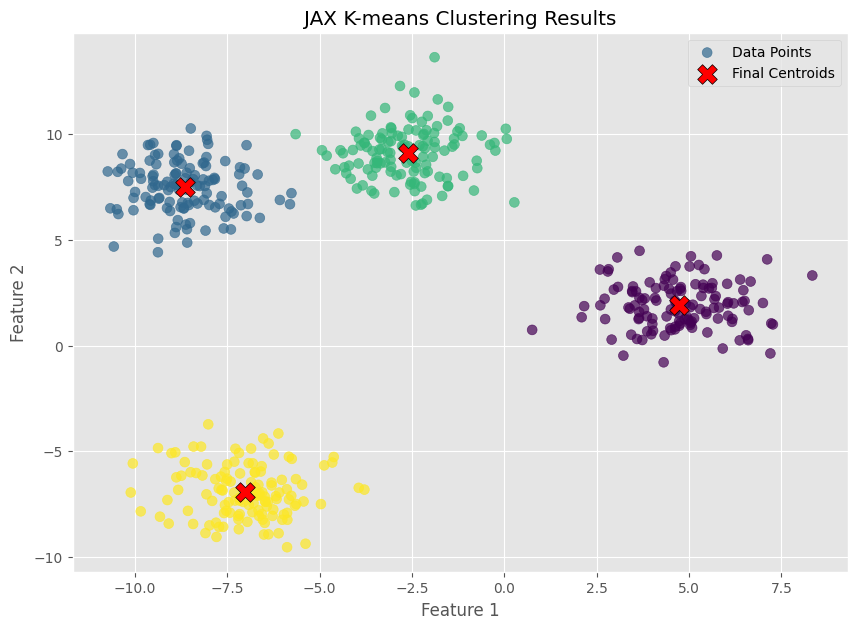

In [82]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# --- 1. Generate Sample Data ---
# Let's create some nicely clustered data to test the algorithm
n_samples = 500
n_features = 2
n_clusters = 4
random_state = 42

X, y_true = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=1.2,
    random_state=random_state
)

# --- 2. Run the JAX K-means Algorithm ---
# Create a JAX random key
key = random.PRNGKey(0)

# Run the k-means algorithm
print("Running JAX K-means...")
centroids, labels, inertia = jax_kmeans(key, X, k=n_clusters, n_iterations=100)
print(f"K-means finished. Final inertia: {inertia:.2f}")

# --- 3. Use the `predict` function on new data (optional) ---
# For demonstration, we'll just predict on the same data
predicted_labels = predict(centroids, X)
# Check if the labels from the main function and predict are the same
assert jnp.all(labels == predicted_labels)
print("`predict` function works as expected.")

# --- 4. Visualize the Results ---
plt.figure(figsize=(10, 7))

# Plot the data points, colored by their assigned cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50, alpha=0.7, label='Data Points')

# Plot the final centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, edgecolor='black', label='Final Centroids')

plt.title('JAX K-means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()